In [1]:
"""check if data read from seqrecord is same as data read by original tartanair dataloader
"""
%load_ext autoreload
%autoreload 2
import itertools

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.data.tartanair.build import TartanAirVideoTransform, TartanAirNoTransform
from src.data.tartanair.tartanair_video import TartanAirVideoDataset

# load original tartanair dataset
modalities = ["image_left", "depth_left", "flow_flow"]
json_filepath = "/datadrive/azure_mounted_data/commondataset2/tartanair-release1/train_ann_abandonedfactory_easy.json"
transform = TartanAirVideoTransform()
dataset = TartanAirVideoDataset(
    json_filepath,
    clip_len=1,
    seq_len=16,
    modalities=modalities,
    transform=transform,
    video_name_keyword=None,
)

/datadrive/anaconda3/envs/dataloader-benchmark/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2
from src.benchmarks.seqrecord.dataload_utils import InputConfig
import torchdata.datapipes as dp
from src.benchmarks.seqrecord.seqrecord import SeqRecord
from src.benchmarks.seqrecord.tartanloader import IterTartanAIRDatapipe, list2array
# load iter style datapip
rootdir = "/datadrive/azure_mounted_data/commondataset2/tartanair-release1/abandonedfactory/records"
record = SeqRecord.load_record_from_dict(rootdir)
record.rootdir = rootdir
segment_len = 16
# configs from input modalities
config_path = "/home/azureuser/AutonomousSystemsResearch/dataloader-benchmark/src/benchmarks/seqrecord/config.yaml"
with open(config_path, mode="r") as f:
    import yaml

    config = yaml.safe_load(f)["inputs"]

input_config = InputConfig()
for key, modal in config.items():
    modal["kwargs"]["name"] = key
    input_config.add_input(modal)
datapipe = IterTartanAIRDatapipe(record, segment_len, None)
datapipe = dp.iter.Mapper(datapipe, fn=list2array)
datapipe = dp.iter.Mapper(datapipe, fn=input_config.train_transform)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.float32 torch.Size([3, 224, 224]) tensor(-2.1179) tensor(2.0434)
torch.float32 torch.Size([3, 224, 224]) tensor(-2.1179) tensor(2.0905)
torch.float32 torch.Size([224, 224]) tensor(-4.1663) tensor(6.2044)
torch.float64 torch.Size([224, 224]) tensor(-4.1663, dtype=torch.float64) tensor(6.2044, dtype=torch.float64)
torch.float32 torch.Size([224, 224]) tensor(0.2140) tensor(0.8831)
torch.float32 torch.Size([224, 224]) tensor(0.2140) tensor(0.8831)


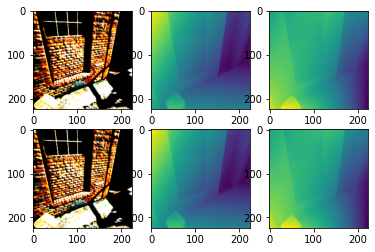

In [34]:
# mannually checking a few (transform)
# check size, range, dtype and value of rgb image
item_idx = 5
old_item = dataset[item_idx]
new_item = next(itertools.islice(datapipe, item_idx, None))

frame_idx = 5
fig, axs = plt.subplots(nrows=2, ncols=len(modalities), squeeze=False)
# rgb
modality = 'image_left'
old_rgb = old_item[modality][0].permute(1, 0, 2, 3)[frame_idx]
new_rgb = new_item[modality][frame_idx]
print(old_rgb.dtype, old_rgb.size(), old_rgb.min(), old_rgb.max())
print(new_rgb.dtype, new_rgb.size(), new_rgb.min(), new_rgb.max())
old_rgb = old_rgb.permute(1, 2, 0)
new_rgb = new_rgb.permute(1, 2, 0)
axs[0, 0].imshow(np.asarray(old_rgb))
axs[1, 0].imshow(np.asarray(new_rgb))

modality = 'flow_flow'
old_flow = old_item[modality][0].permute(1, 0, 2, 3)[frame_idx]
new_flow = new_item[modality][frame_idx]
old_flow = old_flow[0]
new_flow = new_flow[0, :, :]
print(old_flow.dtype, old_flow.size(), old_flow.min(), old_flow.max())
print(new_flow.dtype, new_flow.size(), new_flow.min(), new_flow.max())

axs[0, 2].imshow(np.asarray(old_flow))
axs[1, 2].imshow(np.asarray(new_flow))

modality = 'depth_left'
old_depth = old_item[modality][0].permute(1, 0, 2, 3)[frame_idx]
new_depth = new_item[modality][frame_idx]
old_depth = old_depth[0]
print(old_depth.dtype, old_depth.size(), old_depth.min(), old_depth.max())
print(new_depth.dtype, new_depth.size(), new_depth.min(), new_depth.max())
axs[0, 1].imshow(np.asarray(old_depth))
axs[1, 1].imshow(np.asarray(new_depth))
torch.testing.assert_allclose(old_rgb, new_rgb)
torch.testing.assert_allclose(old_flow, new_flow)# 
torch.testing.assert_allclose(old_depth, new_depth)